# CNN to identify COVID-19 mask types

In [1]:
# import fastai library
from fastai2.vision.all import *
from fastai2.vision.widgets import *
from utils import *

## Curate a dataset of mask images using Bing image search

In [3]:
key = 'xxxxxxxxxxxxxxxx' # api key for bing image search

Try downloading a single image to begin with

In [4]:
# get a list of urls of images on the internet
results = search_images_bing(key, 'N95 respirator')
urls = results.attrgot('content_url')
urls

(#149) ['https://news.immitate.com/wp-content/uploads/2020/03/3m-doubles-output-of-n95-respirator-masks-amid-coronavirus-outbreak-new-york-post.jpg','https://www.federalresources.com/wp-content/uploads/3M-N95-Mask.jpg','https://cdn.shopify.com/s/files/1/2448/2573/products/N95RespiratorMasks2_1200x1200.jpg?v=1581621795','http://cdn.shopify.com/s/files/1/0106/5435/1460/products/bbde1a37-9aa4-4988-9f9d-4ca8dc840aed_1200x1200.jpg?v=1581358432','https://cdn.shopify.com/s/files/1/2546/9230/products/mask_web-26_1200x1200.jpg?v=1584126056','https://cdn.shopify.com/s/files/1/2546/9230/products/mask_web-13_1200x1200.jpg?v=1584126056','https://cdn.shopify.com/s/files/1/1824/7293/products/DUSK-MASK-FRONT-6-CONTENT_1024x1024.jpg?v=1580785028','https://cdn.shopify.com/s/files/1/2546/9230/products/mask_web-07_1200x1200.jpg?v=1584126056','https://cdn.shopify.com/s/files/1/2201/8199/products/coronavirus-face-mask-n95_41bebca8-e764-4a10-a08d-f44a2cf4cdfa_grande.jpg?v=1580687160','https://cdn.shopify.com

In [5]:
dest = 'images/n95.jpg'
download_url(urls[1], dest) # download the image

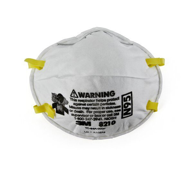

In [6]:
# display the image
img = Image.open(dest)
img.to_thumb(192, 192)

Download images for all the classes

In [13]:
mask_types = 'N95 respirator', 'surgical mask'
path = Path('masks')

In [8]:
path.mkdir(exist_ok=True)

for mask in mask_types:
    mask = mask.replace(" ", "")
    dest = (path/mask)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, mask)
    download_images(dest, urls=results.attrgot('content_url'))

**Check and remove corrupted images**

In [3]:
fns = get_image_files(path)
fns

(#284) [Path('masks/N95respirator/00000001.jpg'),Path('masks/N95respirator/00000000.jpg'),Path('masks/N95respirator/00000002.jpg'),Path('masks/N95respirator/00000006.jpg'),Path('masks/N95respirator/00000009.jpg'),Path('masks/N95respirator/00000005.jpg'),Path('masks/N95respirator/00000010.jpg'),Path('masks/N95respirator/00000004.jpg'),Path('masks/N95respirator/00000013.jpg'),Path('masks/N95respirator/00000007.jpg')...]

In [10]:
corrupted = verify_images(fns)
corrupted

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#9) [Path('masks/N95respirator/00000003.jpg'),Path('masks/N95respirator/00000142.jpg'),Path('masks/surgicalmask/00000065.jpg'),Path('masks/surgicalmask/00000070.jpg'),Path('masks/surgicalmask/00000071.jpg'),Path('masks/surgicalmask/00000074.jpg'),Path('masks/surgicalmask/00000092.jpg'),Path('masks/surgicalmask/00000112.jpg'),Path('masks/surgicalmask/00000129.jpg')]

In [11]:
# delete the images
corrupted.map(Path.unlink)

(#9) [None,None,None,None,None,None,None,None,None]

## Create DataLoaders

*Using higher level API*

In [20]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.3, seed=672,
            item_tfms=RandomResizedCrop(224, min_scale=0.5),
            batch_tfms=aug_transforms())

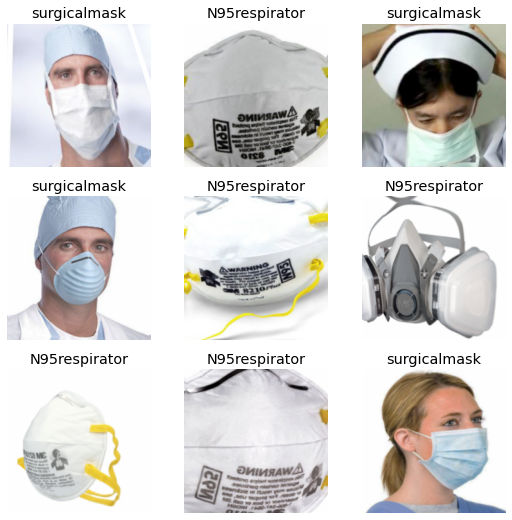

In [21]:
dls.show_batch(max_n=9, nrows=3)

*Using the DataBlock API*

In [3]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=672),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [4]:
dls = db.dataloaders(path)

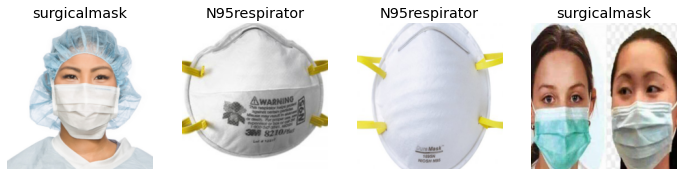

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

## Create learner and train the model

In [5]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.957833,0.513136,0.104651,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.434755,0.295021,0.058140,00:04
1,0.391955,0.154647,0.034884,00:04
2,0.321810,0.100864,0.046512,00:04
3,0.258749,0.075316,0.046512,00:04
4,0.228420,0.063267,0.023256,00:04


In [15]:
learn.export('export1.pkl')

## Visualize the models predictions and use it to clean the data

In [6]:
interp = ClassificationInterpretation.from_learner(learn)

*Plot confusion matrix*

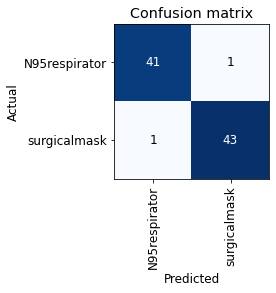

In [7]:
interp.plot_confusion_matrix()

*Show top losses ie. the images that the model was not able to rightly classify*

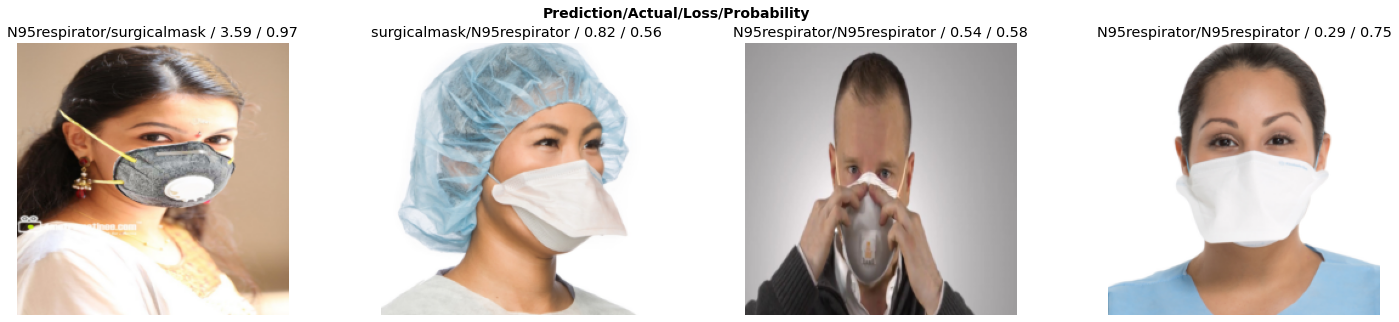

In [13]:
interp.plot_top_losses(4, nrows=1, figsize=(25, 5))

*Use Cleaner widget to clean the dataset*

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

*Effect the changes that were made*

In [17]:
# delete images that were marked to be deleted
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# move images that were marked to be moved
for idx, cat in cleaner.change():
    src = str(cleaner.fns[idx])
    fn = '0' + src.split('/')[2]
    dst = path/cat/fn
    shutil.move(src, dst)

## Train model again to see improvements

In [18]:
dls = db.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.983611,0.278192,0.093023,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.360740,0.233681,0.081395,00:04
1,0.305075,0.161049,0.046512,00:04
2,0.243486,0.133747,0.023256,00:04
3,0.209260,0.119025,0.023256,00:04
4,0.178098,0.118018,0.011628,00:04
5,0.150651,0.132698,0.023256,00:04
6,0.132090,0.140790,0.023256,00:04
7,0.119585,0.141906,0.023256,00:04


## Save model for inference

In [ ]:
learn.export()

In [3]:
learn_inf = load_learner('export1.pkl')

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

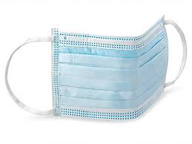

In [35]:
img = PILImage.create(btn_upload.data[-1])
img.to_thumb(192,192)

In [36]:
learn_inf.predict(img)

('surgicalmask', tensor(1), tensor([0.0057, 0.9943]))

# Create notebook app from the model

1. Create a label to display instructions
2. Create a file upload button to upload image
3. Create an output widget to display the image
4. Get predictions
5. Create a label to display the predictions
6. Create a button to trigger the classification
7. Create a click event handler to handle the whole process
8. Put all widgets together into a VBox

In [37]:
ins_label = widgets.Label('Know your mask type')

In [38]:
btn_upload = widgets.FileUpload()

In [39]:
out = widgets.Output()

In [40]:
preds_label = widgets.Label()

In [41]:
btn_classify = widgets.Button(description='Classify')

In [42]:
def on_click(change):
    # get uploaded image
    img = PILImage.create(btn_upload.data[-1])
    # display image
    out.clear_output()
    with out: display(img.to_thumb(192, 192))
    # get predictions
    pred, pred_idx,probs = learn_inf.predict(img)
    # display predictions
    preds_label.value = f'Prediction: {pred}\nProbability: {probs[pred_idx]:.04f}'
    
btn_classify.on_click(on_click)

In [43]:
btn_upload = widgets.FileUpload() # reset the upload button

VBox([ins_label, btn_upload, btn_classify, out, preds_label])

In [21]:
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.21 OK


## Deploy model on [SeeMe.ai](https://app.seeme.ai/)

In [ ]:
# Install the SeeMe SDK
!pip install seeme

In [4]:
from seeme import Client

In [5]:
client = Client() # create a SeeMe client

In [ ]:
# register an account on SeeMe
my_password =  "xxxxxxxxx"
my_username =  "xxxxxxxx"
my_email =   "xxxxxx@xxxxxxx.xxxxx"
my_firstname =   "xxxxx"
my_name =  "xxxxxxx"

client.register(username=my_username, email=my_email, password=my_password, firstname=my_firstname, name=my_name)

In [7]:
client.login(my_username, my_password)

In [8]:
model_name = "COVID-19 Masks"
description = "Identify the type of mask you're using"
classes = "N95 respirator and Surgical mask"

my_model = client.create_full_model({
    "name": model_name,
    "description": description,
    "classes": classes,
    "framework": "fastai",
    "version": "2"
})

In [12]:
# deploy the model
client.upload_model(my_model["ID"], folder='.', filename='export.pkl')

"{'OK': 'Yes'}"

## Digging into item transforms and batch transforms
---

*This section came earlier in lesson 2 but I just couldn't to build and deploy the model*

In [29]:
# let's recreate the datablock without the batch transforms
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

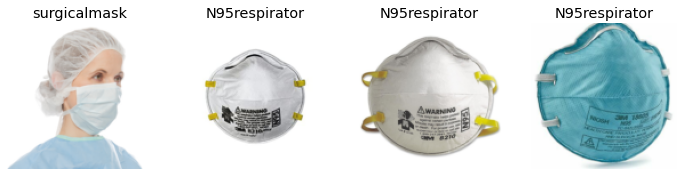

In [30]:
dls = db.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Item transforms are applied to each item(image). By default, Resize crops the images to fit a square of the size provided. However, this may lead to losing some important parts of the image. Other options are to squish/stretch the image or to pad with zeros.

**Squish**

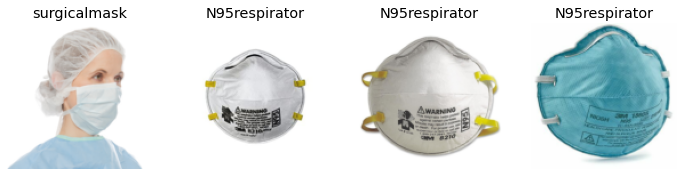

In [31]:
# create a new DataBlock with other item transforms
db = db.new(item_tfms=Resize(128, method=ResizeMethod.Squish))
dls = db.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**Pad**

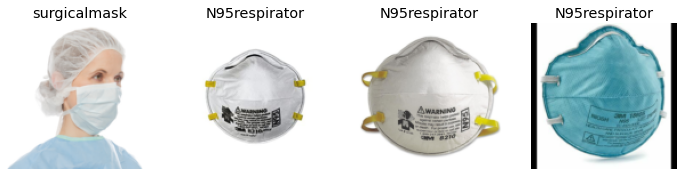

In [32]:
db = db.new(item_tfms=Resize(128, method=ResizeMethod.Pad, pad_mode='zeros'))
dls = db.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In practice however, we randomly select part of the image and crop to just that part. With this, we see a slightly different variation of the image at each epoch.

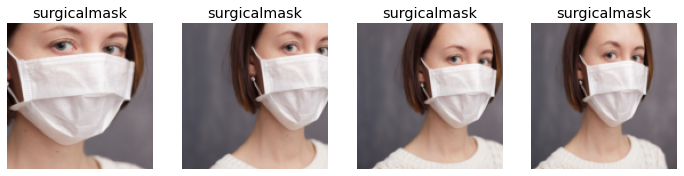

In [34]:
db = db.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = db.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

### Data Augmentation

In [35]:
db = db.new(
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2))

dls = db.dataloaders(path)

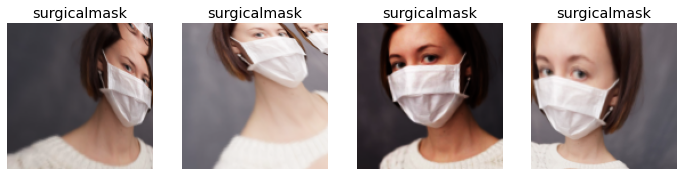

In [36]:
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)